Marta Xiulan Aribó Herrera and German Anashkin

Data Driven Social Analytics - Assignment II

MIIS 2025

---



# Installs and Libraries

In [1]:
!pip install snap-stanford pandas numpy matplotlib seaborn tqdm networkx powerlaw

In [2]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
import os
import pandas as pd
import powerlaw as pl
import seaborn as sns
import snap

from tqdm import tqdm

In [3]:
# sns.set_theme()

# Download Data (Do not run)

In [ ]:
!wget http://www.sociopatterns.org/files/datasets/004/sg_infectious_contact_list.tgz

In [ ]:
!mkdir -p ../sociopatterns
!tar -xzf sg_infectious_contact_list.tgz -C ../sociopatterns
!ls ../sociopatterns

In [ ]:

dataset = pd.DataFrame()
read_path = "../sociopatterns/"
save_path = "../data/"
for file in os.listdir(read_path):
  file = read_path + file
  df = pd.read_csv(file, delimiter='\t')
  df.columns = ['contact_time', 'user_1', 'user_2']
  dataset = pd.concat([dataset, df])

dataset.to_csv(save_path+"infectious_data.csv", index=False)

# Load Dataset

In [4]:
path = "../data/infectious_data.csv"
df = pd.read_csv(path)

# Converting UNIX time to datetime format
df['contact_time'] = df['contact_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

## Graph Generation

In [5]:
# Graph creation

G = snap.TUNGraph.New()

for idx, row in tqdm(df.iterrows(), total=len(df)):
    if not G.IsNode(row['user_1']):
        G.AddNode(row['user_1'])

    if not G.IsNode(row['user_2']):
        G.AddNode(row['user_2'])

    G.AddEdge(row['user_1'], row['user_2'])

G.PrintInfo()

100%|██████████| 415843/415843 [00:12<00:00, 34186.16it/s]

Graph:
  Nodes:                    10972
  Edges:                    44516
  Zero Deg Nodes:           0
  Zero InDeg Nodes:         0
  Zero OutDeg Nodes:        0
  NonZero In-Out Deg Nodes: 10972


In [6]:
# Save the graph
save_graph = snap.TFOut("../data/infectious.graph")
G.Save(save_graph)

In [7]:
# Load the graph
load_graph = snap.TFIn("../data/infectious.graph")
G = snap.TUNGraph.Load(load_graph)

# 1. Dataset Analysis

## a. General Characteristics of the Dataset

[DATASET LINK:  Infectious SocioPatterns dynamic contact networks](href="http://www.sociopatterns.org/datasets/infectious-sociopatterns-dynamic-contact-networks/")

This dataset records face-to-face interactions between individuals overt time. It is structure into three columns: *user_1*, *user_2* and *contact_time*. Each row represents a recorded contact event between two individuals at a specific time. These names have been labeled by us for better understanding.

* *user_1* and *user_2* : Unique and anonymous identifiers assigned to individuals involved in a contact event.
* *contact_time* :  A timestamp representing the time interval [t-20s, t] during which the two individuals were in contact. The time is expressed in UNIX ctime format.

The dataset have shape of 415843 x 3

In [8]:
df.head()

,contact_time,user_1,user_2
0,2009-06-04 12:19:19,90505314,78184522
1,2009-06-04 12:19:19,90505314,78446676
2,2009-06-04 12:19:19,90505314,78577729
3,2009-06-04 12:19:19,78184522,75104339
4,2009-06-04 12:19:19,78446676,74973244


In [9]:
def round_2_sig_fig(x):
    if x == 0: return 0
    return round(x, -int(np.floor(np.log10(abs(x))) - 1))

def get_general_characteristics(G):
    nodes_degree = [node.GetDeg() for node in G.Nodes()]
    num_nodes = G.GetNodes()
    num_edges = G.GetEdges()
    density = 2*num_edges/((num_nodes-1)*num_nodes)
    string = f"""   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : {G.GetNodes()}
    Number of edges     : {G.GetEdges()}
    Density             : {round_2_sig_fig(density)}
    Average Degree      : {round_2_sig_fig(np.mean(nodes_degree))}
    Median Degree       : {round_2_sig_fig(np.median(nodes_degree))}
    Max Degree          : {round_2_sig_fig(np.max(nodes_degree))}
    Min Degree          : {round_2_sig_fig(np.min(nodes_degree))}
    ---------------------------------------------------
    """
    
    return string

res = get_general_characteristics(G)
print(res)

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.00074
    Average Degree      : 8.1
    Median Degree       : 6.0
    Max Degree          : 64
    Min Degree          : 1
    ---------------------------------------------------
    


## b. Node Centrality
Refers to the importance of a node given a graph, how central is the node related to the network. We are going to be measuring this metric using at least three different methods. [Snap doc.](href="https://snap.stanford.edu/snappy/doc/reference/centr.html")

### Degree Centrality ([GetDegreeCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetDegreeCentr.html))
A graph method for undirected graphs that returns degree centrality of a given node NId. Degree centrality of a node is defined as its degree/(N-1), where N is the number of nodes in the graph.

In [10]:
def get_degree_centrality(G):
    degree_centrality = {}
    for node in tqdm(G.Nodes(), total=G.GetNodes()):
        degree_centrality[node.GetId()] = G.GetDegreeCentr(node.GetId())

    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_degree_centrality[:5]):
        contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].dt.date.unique()
        degree = G.GetNI(node).GetDeg()
        string += f"""
    Visitor (Node) {node} has degree centrality of {round_2_sig_fig(centrality)}. Node Degree: {degree}. Visit date {contact_time}.
        """        
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_degree_centrality(G)  
print(res)


100%|██████████| 10972/10972 [00:00<00:00, 599631.30it/s]

   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.0058. Node Degree: 64. Visit date [datetime.date(2009, 5, 17)].
        
    Visitor (Node) 90636462 has degree centrality of 0.0046. Node Degree: 50. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 94961689 has degree centrality of 0.0044. Node Degree: 48. Visit date [datetime.date(2009, 7, 14)].
        
    Visitor (Node) 81068077 has degree centrality of 0.0043. Node Degree: 47. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 80150715 has degree centrality of 0.0042. Node Degree: 46. Visit date [datetime.date(2009, 7, 14)].
        
    ---------------------------------------------------
    


### Closeness Centrality ([GetClosenessCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetClosenessCentr.html))
A graph method that returns closeness centrality of a given node NId. Closeness centrality is equal to 1/farness centrality.

In [11]:
def get_closeness_centrality(G):
    closeness_centrality = {}
    for node in tqdm(G.Nodes(), total=G.GetNodes()):
        closeness_centrality[node.GetId()] = snap.GetClosenessCentr(G, node.GetId())

    sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_closeness_centrality[:5]):
        contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].dt.date.unique()
        degree = G.GetNI(node).GetDeg()
        string += f"""
    Visitor (Node) {node} has closeness centrality of {round_2_sig_fig(centrality)}. Node Degree: {degree}. Visit date {contact_time}.
        """        
      
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_closeness_centrality(G)
print(res)

100%|██████████| 10972/10972 [00:00<00:00, 25364.43it/s]

   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 77070363 has closeness centrality of 0.015. Node Degree: 30. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 90636462 has closeness centrality of 0.015. Node Degree: 50. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 73597118 has closeness centrality of 0.014. Node Degree: 26. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 89587733 has closeness centrality of 0.014. Node Degree: 33. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 102629386 has closeness centrality of 0.014. Node Degree: 24. Visit date [datetime.date(2009, 7, 15)].
        
    ---------------------------------------------------
    


### Farness Centrality ([GetFarnessCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetFarnessCentr.html))
A graph method that returns farness centrality of a given node NId. Farness centrality of a node is the average shortest path length to all other nodes that reside in the same connected component as the given node.

In [12]:
def get_farness_centrality(G):
    farness_centrality = {}
    for node in tqdm(G.Nodes(), total=G.GetNodes()):
        farness_centrality[node.GetId()] = snap.GetFarnessCentr(G, node.GetId())

    sorted_farness_centrality = sorted(farness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    string = f"""   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_farness_centrality[:5]):
        contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].dt.date.unique()
        degree = G.GetNI(node).GetDeg()
        string += f"""
    Visitor (Node) {node} has farness centrality of {round_2_sig_fig(centrality)}. Node Degree: {degree}. Visit date {contact_time}.
        """        
    
    
    string += f"""
    ---------------------------------------------------
    """

    return string

res = get_farness_centrality(G)
print(res)

100%|██████████| 10972/10972 [00:00<00:00, 24202.25it/s]

   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 101843033 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 6, 4)].
        
    Visitor (Node) 98304080 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 6, 4)].
        
    Visitor (Node) 78577731 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 6, 4)].
        
    Visitor (Node) 96403528 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 6, 4)].
        
    Visitor (Node) 78118988 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 6, 4)].
        
    ---------------------------------------------------
    


### Eigenvector Centrality ([GetEigenVectorCentr()](ref:https://snap.stanford.edu/snappy/doc/reference/GetEigenVectorCentr.html))
A graph method for undirected graphs that returns eigenvector centrality of all nodes. Eigenvector Centrality of a node N is defined recursively as the average of centrality values of N’s neighbors in the network.

In [13]:
def get_eigenvector_centrality(G):
    eigenvector_centrality = {}
    NIdEigenH = G.GetEigenVectorCentr()

    for node in tqdm(NIdEigenH, total=NIdEigenH.Len()):

        eigenvector_centrality[node] = NIdEigenH[node]

    sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
    string = f"""
    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    """

    for idx, (node, centrality) in enumerate(sorted_eigenvector_centrality[:5]):
        contact_time = df[(df['user_1'] == node) | (df['user_2'] == node)]['contact_time'].dt.date.unique()
        degree = G.GetNI(node).GetDeg()
        string += f"""
    Visitor (Node) {node} has eigenvector centrality of {round_2_sig_fig(centrality)}. Node Degree: {degree}. Visit date {contact_time}.
        """        
    

    string += f"""
    ---------------------------------------------------
    """
    return string

res = get_eigenvector_centrality(G)
print(res)

100%|██████████| 10972/10972 [00:00<00:00, 625160.01it/s]


    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 78905411 has eigenvector centrality of 0.21. Node Degree: 32. Visit date [datetime.date(2009, 5, 28)].
        
    Visitor (Node) 73400401 has eigenvector centrality of 0.2. Node Degree: 31. Visit date [datetime.date(2009, 5, 28)].
        
    Visitor (Node) 104529997 has eigenvector centrality of 0.2. Node Degree: 31. Visit date [datetime.date(2009, 5, 28)].
        
    Visitor (Node) 78839891 has eigenvector centrality of 0.2. Node Degree: 30. Visit date [datetime.date(2009, 5, 28)].
        
    Visitor (Node) 100991066 has eigenvector centrality of 0.19. Node Degree: 30. Visit date [datetime.date(2009, 5, 28)].
        
    ---------------------------------------------------
    


## c. Average path length, diameter, effective diameter

In [14]:
def get_path_length_diameter(G):
    res = G.GetBfsEffDiamAll(10, False)
    eff_diameter = (res[0], res[1])
    diameter = res[2]
    avg_shortest_path = res[3]

    string = f"""   
    ---------------------------------------------------
    Average Path Length : {round_2_sig_fig(avg_shortest_path)}
    Diameter            : {round_2_sig_fig(diameter)}
    Effective Diameter  : {round_2_sig_fig(eff_diameter[0]), round_2_sig_fig(eff_diameter[1])}
    ---------------------------------------------------
    """

    return string

res = get_path_length_diameter(G)
print(res)

   
    ---------------------------------------------------
    Average Path Length : 4.6
    Diameter            : 14
    Effective Diameter  : (7.5, 7.5)
    ---------------------------------------------------
    


## d. The innermost k-shell

Using the methods GetKCore, GetKCoreNodes and GetKCoreEdges (doc [here](href:https://snap.stanford.edu/snappy/doc/reference/kcore.html?highlight=core))

In [15]:
def get_innermos_k_shell(G):
    max_k_val, order_k_nodes= G.GetKCoreNodes()
    num_nodes_per_k = [(item.GetVal1(), item.GetVal2()) for item in order_k_nodes]

    max_k_val, order_k_edges= G.GetKCoreEdges()
    num_edges_per_k = [(item.GetVal1(), item.GetVal2()) for item in order_k_edges]

    string = f"""   
    ---------------------------------------------------
    Innermost k-shell : {max_k_val-1}
    Number of nodes   : {num_nodes_per_k[-1][1]}
    Number of edges   : {num_edges_per_k[-1][1]}
    ---------------------------------------------------
    """

    return string

res = get_innermos_k_shell(G)
print(res)

   
    ---------------------------------------------------
    Innermost k-shell : 18
    Number of nodes   : 55
    Number of edges   : 595
    ---------------------------------------------------
    


## e. The clustering coefficient [GetClustCf()](href:https://snap.stanford.edu/snappy/doc/reference/GetClustCf.html?highlight=clustering%20coefficient)
A graph method that computes the average clustering coefficient as defined in Watts and Strogatz, Collective dynamics of ‘small-world’ networks.  Is a measure of the degree to which nodes in a graph tend to cluster together

In [16]:
def get_cluster_coeff(G):
    cluster_coeff = snap.GetClustCf(G)
    string = f"""
    ---------------------------------------------------
    Clustering Coefficient : {round_2_sig_fig(cluster_coeff)}
    ---------------------------------------------------
    """
    return string

res = get_cluster_coeff(G)
print(res)


    ---------------------------------------------------
    Clustering Coefficient : 0.45
    ---------------------------------------------------
    


# 2. Degree Distribution
We calculate the degree distribution and then we perform a fit using the library powerlaw.

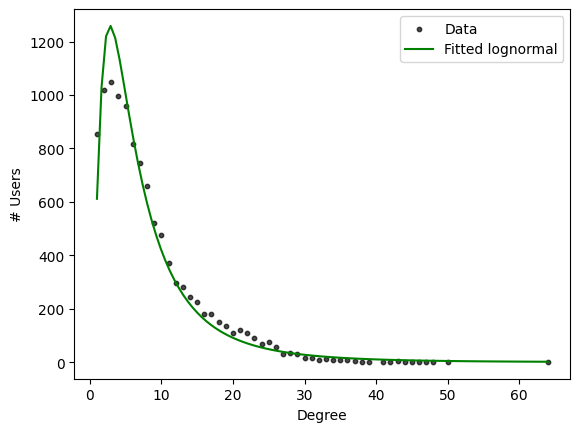

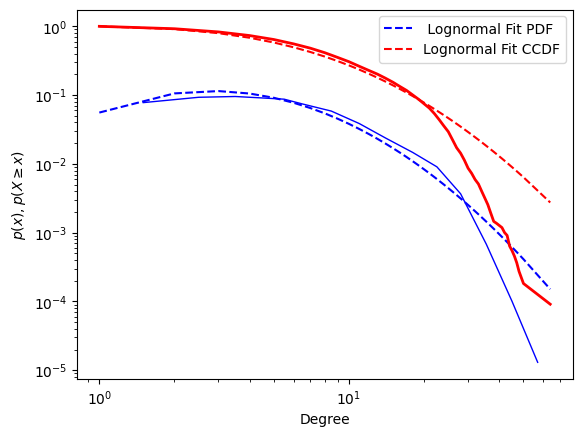


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : -75.863017599781
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Sigma       : 0.8614766858350882
Mu          : 1.760962210743725
Xmin        : 1.0   
KS          : 0.06128268940050152
---------------------------------------------------



In [17]:
def get_degree_distr(G, distributions, xmin=None, file_path=None):
    degree_freq_list = [node.GetDeg() for node in G.Nodes()]
    
    DegToCntV = G.GetDegCnt()
    degree_freq_dict = {item.GetVal1(): item.GetVal2() for item in DegToCntV}
    degrees = np.array(list(degree_freq_dict.keys()))
    frequencies = np.array(list(degree_freq_dict.values()))
    
    fit = pl.Fit(degree_freq_list, discrete=True, xmin=xmin, bin_edges=True) 

    R, p = fit.distribution_compare(distributions[0], distributions[1], normalized_ratio=True)

    if R > 0:
        dist_name = distributions[0]
        selected_dist = getattr(fit, dist_name)
    else:
        dist_name = distributions[1]
        selected_dist = getattr(fit, dist_name)

    x_range = np.linspace(selected_dist.xmin, max(degree_freq_list), 100)
    y_range = [selected_dist.pdf(x) * len(degree_freq_list) for x in x_range]

    plt.figure(dpi=100, )
    plt.scatter(degrees, frequencies, s=10, alpha=0.7, color='black', label="Data")
    plt.plot(x_range, y_range, color='g', linestyle='-', label=f"Fitted {dist_name}")
    plt.xlabel("Degree")
    plt.ylabel("# Users")
    plt.legend()
    plt.savefig(f"{file_path}_degree_distr.png")
    plt.show()

    fig, ax = plt.subplots(dpi=100)
    selected_dist.plot_pdf(ax=ax, color='b', linestyle='--', label=f" {dist_name.capitalize()} Fit PDF")
    fit.plot_pdf(color='b', linewidth=1, ax=ax)
    fit.plot_ccdf(color='r', linewidth=2, ax=ax)
    selected_dist.plot_ccdf(ax=ax, color='r', linestyle='--', label=f"{dist_name.capitalize()} Fit CCDF")
    ax.set_xlabel("Degree")
    ax.set_ylabel("$p(x), p(X \geq x)$")
    ax.legend()
    plt.savefig(f"{file_path}_pdf_ccdf.png")
    plt.show()
    

    string = f"""
---------------------------------------------------
{dist_name.upper()} DISTRIBUTION FIT
R          : {R}
p          : {p}
---------------------------------------------------
Alpha       : {getattr(selected_dist, 'alpha', 'N/A')}
Sigma       : {getattr(selected_dist, 'sigma', 'N/A')}
Mu          : {getattr(selected_dist, 'mu', 'N/A')}
Xmin        : {selected_dist.xmin}   
KS          : {selected_dist.D}
---------------------------------------------------
"""
    return string

print(get_degree_distr(G, ['power_law', 'lognormal'], xmin=1, file_path="../images/infectious_degree_distr"))


# 3. Network Comparison

In [18]:
num_nodes = G.GetNodes()
num_edges = G.GetEdges()

random = snap.TRnd(42)

## [Preferential Attachment Network](ref:https://snap.stanford.edu/snappy/doc/reference/GenGeoPrefAttach.html?highlight=pref)

In [19]:
# Because it is a unidrected graph there is no out-degree and in-degree

nodes_degree = [node.GetDeg() for node in G.Nodes()]
avg_node_degree = np.mean(nodes_degree)

G_pref_attach = snap.GenPrefAttach(num_nodes, round(avg_node_degree), random)

In [20]:
path = "../results/preferential_attachment_network.txt"
f = open(path, "a")

res_pref_attach = get_general_characteristics(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_degree_centrality(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_closeness_centrality(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_farness_centrality(G_pref_attach)
print(res_pref_attach)

res_pref_attach = get_eigenvector_centrality(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_path_length_diameter(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_innermos_k_shell(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)

res_pref_attach = get_cluster_coeff(G_pref_attach)
f.write(res_pref_attach)
print(res_pref_attach)


   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 87740
    Density             : 0.0015
    Average Degree      : 16.0
    Median Degree       : 11.0
    Max Degree          : 400
    Min Degree          : 8
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 792599.35it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 7 has degree centrality of 0.036. Node Degree: 396. Visit date [].
        
    Visitor (Node) 2 has degree centrality of 0.035. Node Degree: 387. Visit date [].
        
    Visitor (Node) 3 has degree centrality of 0.034. Node Degree: 376. Visit date [].
        
    Visitor (Node) 6 has degree centrality of 0.034. Node Degree: 372. Visit date [].
        
    Visitor (Node) 8 has degree centrality of 0.034. Node Degree: 371. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:58<00:00, 186.33it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 7 has closeness centrality of 0.44. Node Degree: 396. Visit date [].
        
    Visitor (Node) 0 has closeness centrality of 0.44. Node Degree: 363. Visit date [].
        
    Visitor (Node) 1 has closeness centrality of 0.44. Node Degree: 358. Visit date [].
        
    Visitor (Node) 3 has closeness centrality of 0.44. Node Degree: 376. Visit date [].
        
    Visitor (Node) 5 has closeness centrality of 0.44. Node Degree: 362. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:57<00:00, 189.80it/s]


   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 8834 has farness centrality of 3.8. Node Degree: 8. Visit date [].
        
    Visitor (Node) 10094 has farness centrality of 3.8. Node Degree: 8. Visit date [].
        
    Visitor (Node) 10215 has farness centrality of 3.8. Node Degree: 8. Visit date [].
        
    Visitor (Node) 10837 has farness centrality of 3.8. Node Degree: 8. Visit date [].
        
    Visitor (Node) 8776 has farness centrality of 3.7. Node Degree: 8. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 973883.77it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 7 has eigenvector centrality of 0.17. Node Degree: 396. Visit date [].
        
    Visitor (Node) 0 has eigenvector centrality of 0.16. Node Degree: 363. Visit date [].
        
    Visitor (Node) 3 has eigenvector centrality of 0.16. Node Degree: 376. Visit date [].
        
    Visitor (Node) 1 has eigenvector centrality of 0.16. Node Degree: 358. Visit date [].
        
    Visitor (Node) 5 has eigenvector centrality of 0.16. Node Degree: 362. Visit date [].
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 3.2
    Diameter            : 5
    Effective Diameter  : (3.6, 3.6)
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Innermost k-shell :

### Degree Distribution

Calculating best minimal value for power law fit


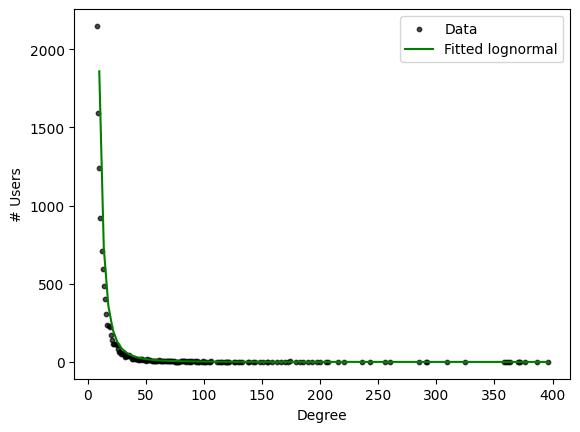

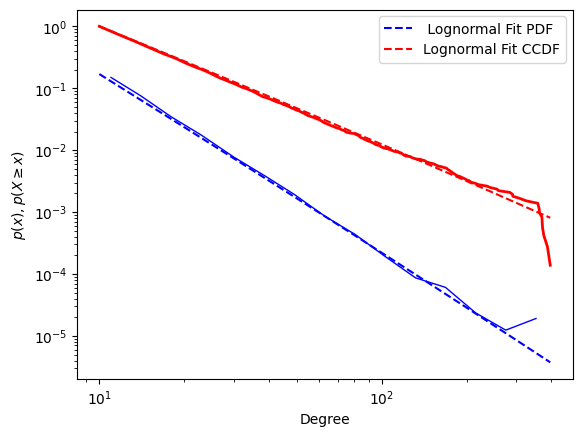


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : -0.5745437637860837
p          : 0.5655998945354485
---------------------------------------------------
Alpha       : N/A
Sigma       : 4.736377884190283
Mu          : -38.7715735511659
Xmin        : 10.0   
KS          : 0.018088392101305195
---------------------------------------------------



In [21]:
print(get_degree_distr(G_pref_attach, ['power_law', 'lognormal'], xmin=None, file_path="../images/preferential_attachment"))

## [Configuration Model](ref:https://snap.stanford.edu/snappy/doc/reference/GenConfModel1.html?highlight=conf)

In [22]:
G_conf_model = snap.GenConfModel(G)

 configuration model: iter 43659: edges: 43639, left: 85677nfiguration model: iter 16929: edges: 16926, left: 27586


In [23]:
path = "../results/configuration_model_network.txt"
f = open(path, "a")

res_conf_model = get_general_characteristics(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_degree_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_closeness_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_farness_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_eigenvector_centrality(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_path_length_diameter(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_innermos_k_shell(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

res_conf_model = get_cluster_coeff(G_conf_model)
f.write(res_conf_model)
print(res_conf_model)

f.close()

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44474
    Density             : 0.00074
    Average Degree      : 8.1
    Median Degree       : 6.0
    Max Degree          : 64
    Min Degree          : 1
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 650412.03it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has degree centrality of 0.0058. Node Degree: 64. Visit date [].
        
    Visitor (Node) 4113 has degree centrality of 0.0046. Node Degree: 50. Visit date [].
        
    Visitor (Node) 354 has degree centrality of 0.0043. Node Degree: 47. Visit date [].
        
    Visitor (Node) 4334 has degree centrality of 0.0043. Node Degree: 47. Visit date [].
        
    Visitor (Node) 372 has degree centrality of 0.0042. Node Degree: 46. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:34<00:00, 317.84it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has closeness centrality of 0.29. Node Degree: 64. Visit date [].
        
    Visitor (Node) 4297 has closeness centrality of 0.28. Node Degree: 43. Visit date [].
        
    Visitor (Node) 372 has closeness centrality of 0.28. Node Degree: 46. Visit date [].
        
    Visitor (Node) 4113 has closeness centrality of 0.28. Node Degree: 50. Visit date [].
        
    Visitor (Node) 10094 has closeness centrality of 0.28. Node Degree: 44. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:33<00:00, 325.19it/s]


   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 2348 has farness centrality of 11000.0. Node Degree: 1. Visit date [].
        
    Visitor (Node) 3499 has farness centrality of 11000.0. Node Degree: 1. Visit date [].
        
    Visitor (Node) 5119 has farness centrality of 11000.0. Node Degree: 1. Visit date [].
        
    Visitor (Node) 5221 has farness centrality of 11000.0. Node Degree: 1. Visit date [].
        
    Visitor (Node) 5294 has farness centrality of 11000.0. Node Degree: 1. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 997224.22it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 5568 has eigenvector centrality of 0.085. Node Degree: 64. Visit date [].
        
    Visitor (Node) 372 has eigenvector centrality of 0.055. Node Degree: 46. Visit date [].
        
    Visitor (Node) 4297 has eigenvector centrality of 0.053. Node Degree: 43. Visit date [].
        
    Visitor (Node) 10094 has eigenvector centrality of 0.051. Node Degree: 44. Visit date [].
        
    Visitor (Node) 4113 has eigenvector centrality of 0.05. Node Degree: 50. Visit date [].
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 4.4
    Diameter            : 8
    Effective Diameter  : (4.9, 4.9)
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Inner

### Degree Distribution

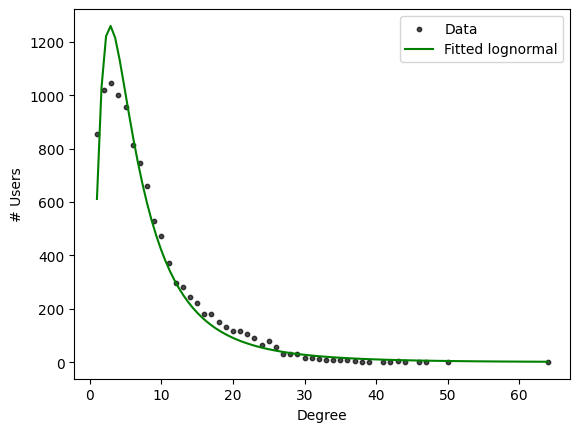

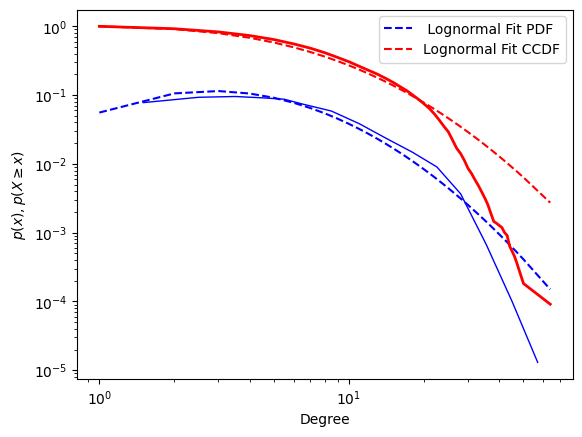


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 75.88897187382409
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Sigma       : 0.8609992112603835
Mu          : 1.7604052943718063
Xmin        : 1.0   
KS          : 0.06115267678452463
---------------------------------------------------



In [24]:
print(get_degree_distr(G_conf_model, ['lognormal', 'power_law'], xmin=1, file_path="../images/configuration_model"))

## [Node Rewiring Model](ref:)

In [25]:
G_rewired = snap.GenRewire(G, 100, random)

Randomizing edges (10972, 44516)...
  total 8903k switchings attempted, 37k skiped  [2.12s]


In [26]:
path = "../results/rewired_network.txt"
f = open(path, "a")

res_rewired = get_general_characteristics(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_degree_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_closeness_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_farness_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_eigenvector_centrality(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_path_length_diameter(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_innermos_k_shell(G_rewired)
f.write(res_rewired)
print(res_rewired)

res_rewired = get_cluster_coeff(G_rewired)
f.write(res_rewired)
print(res_rewired)

f.close()

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.00074
    Average Degree      : 8.1
    Median Degree       : 6.0
    Max Degree          : 64
    Min Degree          : 1
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 283495.99it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has degree centrality of 0.0058. Node Degree: 64. Visit date [datetime.date(2009, 5, 17)].
        
    Visitor (Node) 90636462 has degree centrality of 0.0046. Node Degree: 50. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 94961689 has degree centrality of 0.0044. Node Degree: 48. Visit date [datetime.date(2009, 7, 14)].
        
    Visitor (Node) 81068077 has degree centrality of 0.0043. Node Degree: 47. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 80150715 has degree centrality of 0.0042. Node Degree: 46. Visit date [datetime.date(2009, 7, 14)].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:46<00:00, 233.52it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has closeness centrality of 0.29. Node Degree: 64. Visit date [datetime.date(2009, 5, 17)].
        
    Visitor (Node) 90636462 has closeness centrality of 0.28. Node Degree: 50. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 74317851 has closeness centrality of 0.28. Node Degree: 45. Visit date [datetime.date(2009, 5, 3)].
        
    Visitor (Node) 76611628 has closeness centrality of 0.28. Node Degree: 34. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 74317868 has closeness centrality of 0.28. Node Degree: 43. Visit date [datetime.date(2009, 5, 15)].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:48<00:00, 228.48it/s]


   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558439 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 5, 14)].
        
    Visitor (Node) 100859934 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 7, 12)].
        
    Visitor (Node) 82444459 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 7, 12)].
        
    Visitor (Node) 88604734 has farness centrality of 11000.0. Node Degree: 1. Visit date [datetime.date(2009, 5, 30)].
        
    Visitor (Node) 73596973 has farness centrality of 6.7. Node Degree: 1. Visit date [datetime.date(2009, 5, 12)].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 913673.43it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 83558448 has eigenvector centrality of 0.073. Node Degree: 64. Visit date [datetime.date(2009, 5, 17)].
        
    Visitor (Node) 90636462 has eigenvector centrality of 0.059. Node Degree: 50. Visit date [datetime.date(2009, 7, 15)].
        
    Visitor (Node) 74317851 has eigenvector centrality of 0.056. Node Degree: 45. Visit date [datetime.date(2009, 5, 3)].
        
    Visitor (Node) 80150715 has eigenvector centrality of 0.05. Node Degree: 46. Visit date [datetime.date(2009, 7, 14)].
        
    Visitor (Node) 94699566 has eigenvector centrality of 0.05. Node Degree: 41. Visit date [datetime.date(2009, 5, 16)].
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 4.5
    Diameter            : 8
    Effective Diame

### Degree Distribution

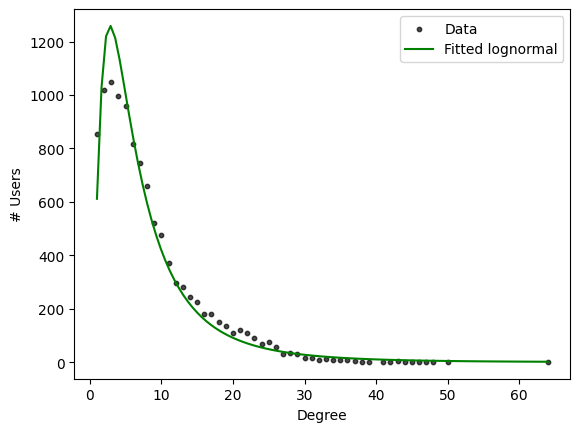

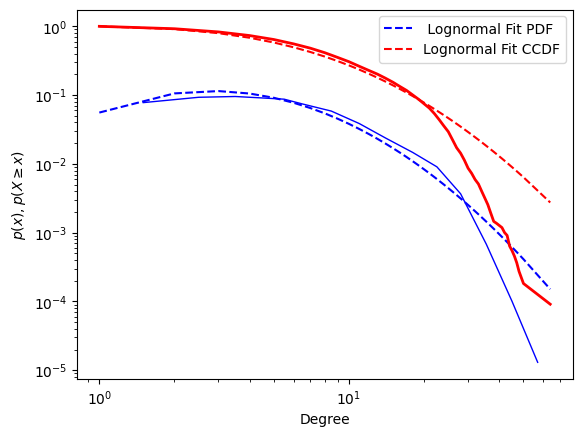


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 75.863017599781
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Sigma       : 0.8614766858350882
Mu          : 1.760962210743725
Xmin        : 1.0   
KS          : 0.06128268940050152
---------------------------------------------------



In [27]:
print(get_degree_distr(G_rewired, ['lognormal', 'power_law'], xmin=1, file_path="../images/rewired_network"))

## [Erdos-Reny random graph](href:https://snap.stanford.edu/snappy/doc/reference/GenRndGnm.html?highlight=erdos)

In [28]:
G_ER = snap.GenRndGnm(snap.PUNGraph, num_nodes, num_edges, False, random)


### Degree Distribution

In [29]:

path = "../results/erdos_renyi_network.txt"
f = open(path, "a")

res_ER = get_general_characteristics(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_degree_centrality(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_closeness_centrality(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_farness_centrality(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_eigenvector_centrality(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_path_length_diameter(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_innermos_k_shell(G_ER)
f.write(res_ER)
print(res_ER)

res_ER = get_cluster_coeff(G_ER)
f.write(res_ER)
print(res_ER)

f.close()

   
    ---------------------------------------------------
    GENERAL CHARACTERISTICS OF THE DATASET
    ---------------------------------------------------
    Name                : Infectious
    Nodes               : Visitor
    Edges               : Face-to-Face Contacts
    Type                : Undirected
    Data Date           : 2009
    ---------------------------------------------------
    Number of nodes     : 10972
    Number of edges     : 44516
    Density             : 0.00074
    Average Degree      : 8.1
    Median Degree       : 8.0
    Max Degree          : 21
    Min Degree          : 0
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 762714.48it/s]


   
    ---------------------------------------------------
    DEGREE CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 9358 has degree centrality of 0.0019. Node Degree: 21. Visit date [].
        
    Visitor (Node) 449 has degree centrality of 0.0018. Node Degree: 20. Visit date [].
        
    Visitor (Node) 3345 has degree centrality of 0.0018. Node Degree: 20. Visit date [].
        
    Visitor (Node) 3470 has degree centrality of 0.0017. Node Degree: 19. Visit date [].
        
    Visitor (Node) 4505 has degree centrality of 0.0017. Node Degree: 19. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:36<00:00, 300.66it/s]


   
    ---------------------------------------------------
    CLOSENESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 449 has closeness centrality of 0.24. Node Degree: 20. Visit date [].
        
    Visitor (Node) 5426 has closeness centrality of 0.24. Node Degree: 19. Visit date [].
        
    Visitor (Node) 8482 has closeness centrality of 0.24. Node Degree: 17. Visit date [].
        
    Visitor (Node) 9358 has closeness centrality of 0.24. Node Degree: 21. Visit date [].
        
    Visitor (Node) 3470 has closeness centrality of 0.24. Node Degree: 19. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:36<00:00, 299.72it/s]


   
    ---------------------------------------------------
    FARNESS CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 2333 has farness centrality of 6.2. Node Degree: 1. Visit date [].
        
    Visitor (Node) 4861 has farness centrality of 5.9. Node Degree: 1. Visit date [].
        
    Visitor (Node) 8725 has farness centrality of 5.8. Node Degree: 2. Visit date [].
        
    Visitor (Node) 10774 has farness centrality of 5.8. Node Degree: 1. Visit date [].
        
    Visitor (Node) 9111 has farness centrality of 5.8. Node Degree: 1. Visit date [].
        
    ---------------------------------------------------
    


100%|██████████| 10972/10972 [00:00<00:00, 992771.08it/s]



    ---------------------------------------------------
    EIGENVECTOR CENTRALITY
    ---------------------------------------------------
    
    Visitor (Node) 449 has eigenvector centrality of 0.029. Node Degree: 20. Visit date [].
        
    Visitor (Node) 5426 has eigenvector centrality of 0.028. Node Degree: 19. Visit date [].
        
    Visitor (Node) 8482 has eigenvector centrality of 0.028. Node Degree: 17. Visit date [].
        
    Visitor (Node) 3470 has eigenvector centrality of 0.028. Node Degree: 19. Visit date [].
        
    Visitor (Node) 9358 has eigenvector centrality of 0.028. Node Degree: 21. Visit date [].
        
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Average Path Length : 4.6
    Diameter            : 7
    Effective Diameter  : (4.9, 4.9)
    ---------------------------------------------------
    
   
    ---------------------------------------------------
    Inner

Values less than or equal to 0 in data. Throwing out 0 or negative values


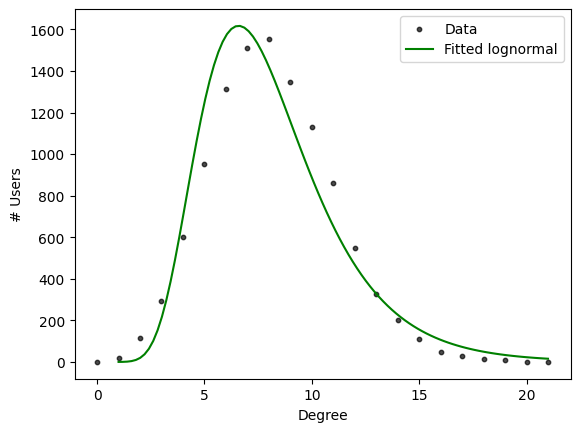

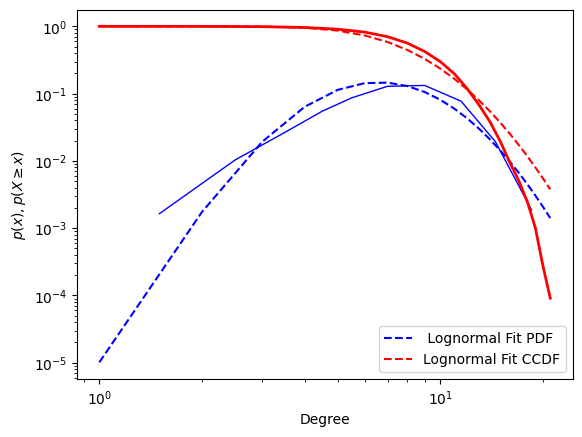


---------------------------------------------------
LOGNORMAL DISTRIBUTION FIT
R          : 155.77076844210526
p          : 0.0
---------------------------------------------------
Alpha       : N/A
Sigma       : 0.38061494713978794
Mu          : 2.027536316839181
Xmin        : 1.0   
KS          : 0.11759098079111285
---------------------------------------------------



In [30]:
print(get_degree_distr(G_ER, ['lognormal', 'power_law'], xmin=1, file_path="../images/erdos_renyi_network"))

# Others

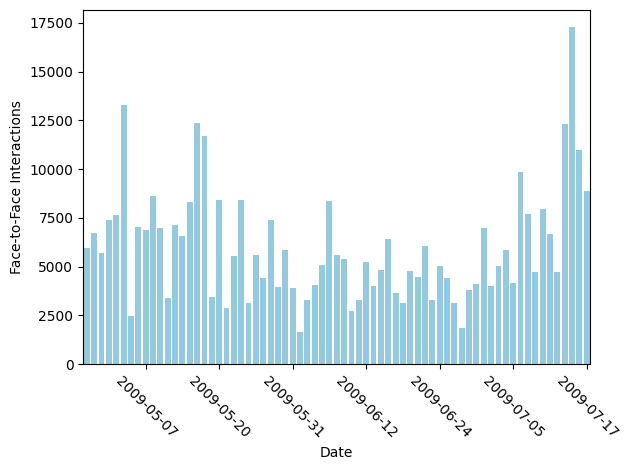

In [31]:
#Face-to-face contact distribution per day

df['date'] = df['contact_time'].dt.date

contact_counts = df.groupby('date').size()

plt.figure(dpi=100)
sns.barplot(contact_counts, color='skyblue')

plt.xlabel('Date')
plt.ylabel('Face-to-Face Interactions')

plt.xticks(rotation=-45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10)) 
plt.tight_layout() 
plt.savefig("../images/face_to_face_contact_distribution.png")
plt.show()
